In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from tensorflow import keras
from sklearn.cluster import KMeans
import random
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from Data_Prepear import data_prepear
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
tf.__version__
from xgboost import XGBRegressor

2024-10-26 02:09:10.846642: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 02:09:10.849460: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 02:09:10.858743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 02:09:10.874687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 02:09:10.879466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 02:09:10.890956: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well4.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# df1 = df1[(df1["dp_tubing"] > 100) & (df1["bhp"] > 200) & (df1["bht"] > 80)]
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2014-04-21', periods=717, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')

df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2014-04-21,256.307459,100.019254,224.314681,100.0,86417.94,0
2014-04-22,256.044791,100.029750,224.437389,100.0,76972.11,1
2014-04-23,256.261189,100.029750,224.690039,100.0,79936.04,2
2014-04-24,256.391532,100.029750,224.811147,100.0,98914.09,3
2014-04-25,256.344846,100.029750,224.707290,100.0,81414.33,4


In [4]:
create_data = data_prepear(df, target_col ="QG", filter_value=65)
X_train, y_train, X_test, y_test = create_data.creator()

In [5]:
# Normalize features 
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (32,1), units= 32, return_sequences = True))
model.add(LSTM(128, activation="relu",return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation="relu",return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))
# model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,217 (1.16 MB)

 Trainable params: 305,217 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_loss',          # Metric to monitor (you can change it)
    save_best_only=True,         # Only save the best model (based on the monitored metric)
    mode='min',                  # 'min' because we want to minimize validation loss
    verbose=1                    # Verbosity mode, to see saving details in console
)
t1 = datetime.datetime.now()
history = model.fit(x=X_train, y=y_train["y_step_1 QG"], epochs=1000, batch_size=30, validation_data = (X_test, y_test["y_step_1 QG"]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=25), checkpoint], verbose=1, shuffle=False)
# EarlyStopping(monitor='val_loss', patience=200), 
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.8017
Epoch 1: val_loss improved from inf to 1.24715, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 1.7659 - val_loss: 1.2471
Epoch 2/1000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.7327
Epoch 2: val_loss did not improve from 1.24715
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6540 - val_loss: 1.2862
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.6588
Epoch 3: val_loss did not improve from 1.24715
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.6228 - val_loss: 1.3579
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.5479
Epoch 4: val_loss did not improve from 1.24715
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.5274 - val_loss: 1.4563
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3898
Epoch 5: val_loss did not improve from 1.24715
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.3596 - val_loss: 1.2925
Epoch 6/1000
19/19 ━━

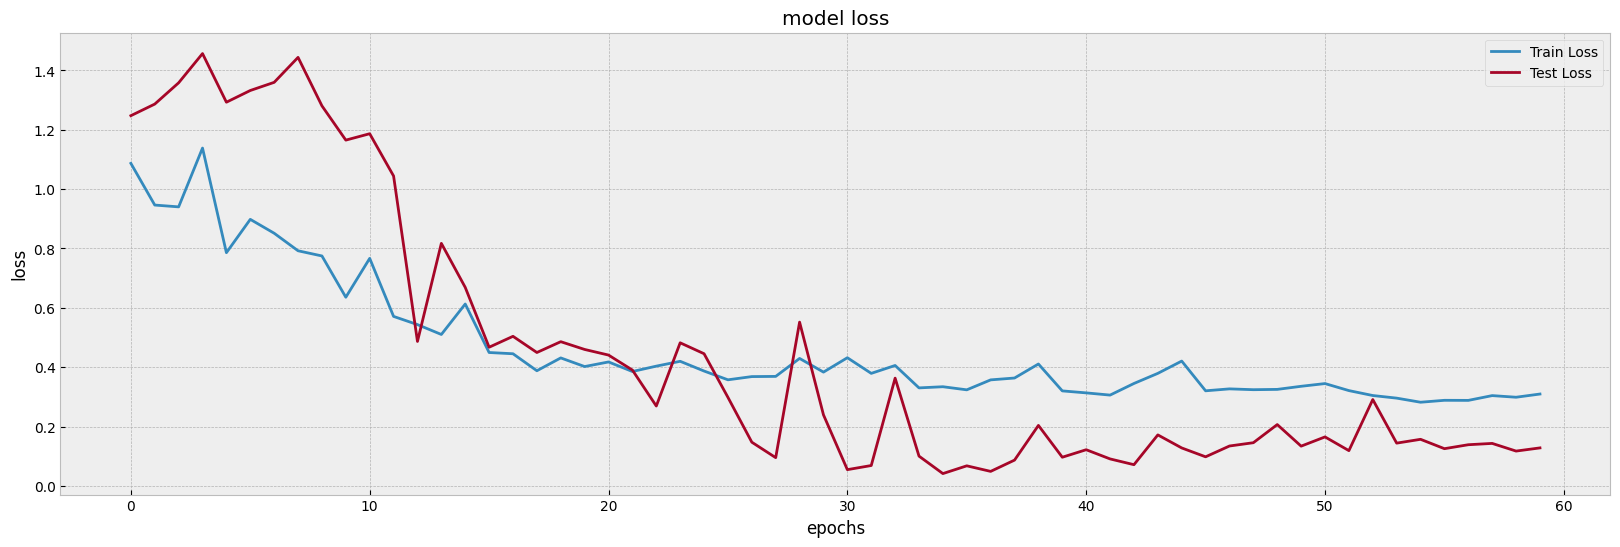

In [7]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [8]:
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [9]:
ss = StandardScaler()
ss.fit(df.QG.values.reshape(df.QG.shape[0],1))
true_y_train = ss.inverse_transform(y_train["y_step_1 QG"].values.reshape(y_train["y_step_1 QG"].shape[0],1))
true_y_test = ss.inverse_transform(y_test["y_step_1 QG"].values.reshape(y_test["y_step_1 QG"].shape[0],1))
true_y_fit = ss.inverse_transform(y_fit)
true_y_pred = ss.inverse_transform(y_pred)

In [10]:
train_rmse = mean_squared_error(true_y_train, true_y_fit, squared=False)
test_rmse = mean_squared_error(true_y_test , true_y_pred, squared=False)
range_train =  np.max(true_y_train) - np.min(true_y_train)
range_test = np.max(true_y_test) - np.min(true_y_test)
print("train RMSE: ",train_rmse)
print("train Range:",range_train)
print("Percent_Erorr:", (train_rmse/range_train)*100, "%")
print("test_RMSE: ", test_rmse)
print("test Range:",range_test)
print("Percent_Erorr:", (test_rmse/range_test)*100, "%")

train RMSE:  8103.543376389792
train Range: 90810.23701084915
Percent_Erorr: 8.923601174415674 %
test_RMSE:  5801.907198589979
test Range: 14015.30421540865
Percent_Erorr: 41.396940868477685 %


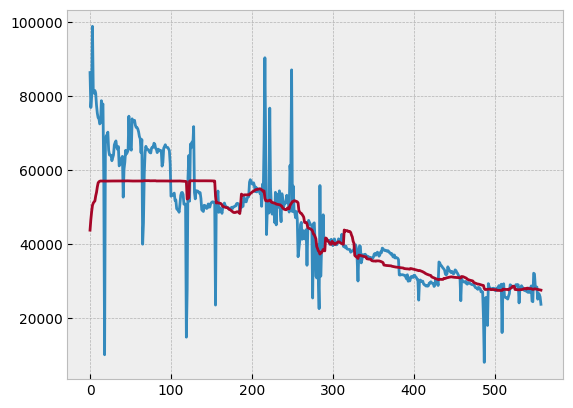

In [11]:
plt.plot(true_y_train)
plt.plot(true_y_fit)

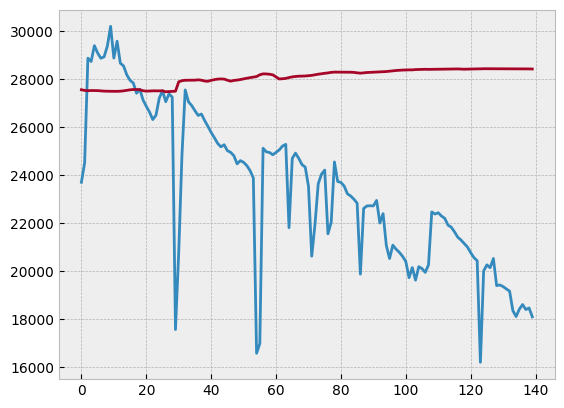

In [12]:
plt.plot(true_y_test)
plt.plot(true_y_pred)

[Text(0.5, 1.0, 'Train'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

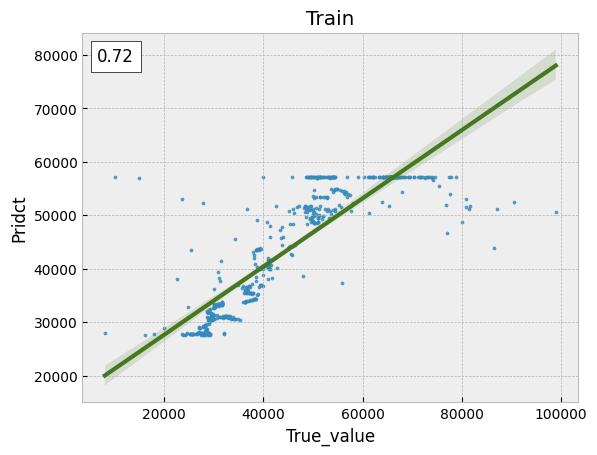

In [13]:
corr = r2_score(true_y_train, true_y_fit)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_train,
    y = true_y_fit,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="Train", xlabel="True_value", ylabel="Pridct")

[Text(0.5, 1.0, 'test'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

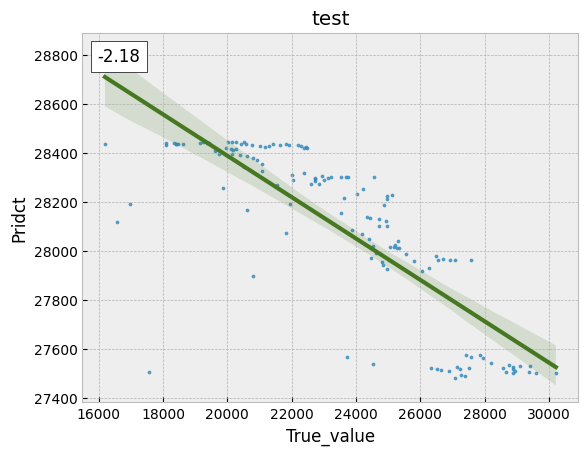

In [14]:
corr = r2_score(true_y_test, true_y_pred)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_test,
    y = true_y_pred,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="test", xlabel="True_value", ylabel="Pridct")